In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit  # Sigmoid function

# Define the sigmoid activation function
def sigmoid(x):
    return expit(x)    

# Define the linear activation function
def linear(x):
    return x

# Define the neural network architecture
class NeuralNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        Initialize the neural network
        :param input_size: number of input neurons
        :param hidden_size: number of hidden neurons
        :param output_size: number of output neurons
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # # Initialize weights and biases using Xavier initialization
        # self.v = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / (input_size + hidden_size))
        # self.v0 = np.zeros(hidden_size)
        # self.w = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / (hidden_size + output_size))
        # self.w0 = np.zeros(output_size)

        # Initialize weights and biases
        self.v = np.random.rand(hidden_size, input_size)
        self.v0 = np.random.rand(hidden_size)
        self.w = np.random.rand(output_size, hidden_size)
        self.w0 = np.random.rand(output_size)

    def predict(self, phi: np.ndarray) -> np.ndarray:   
        """
        Make a prediction with the neural network
        :param phi: input data
        :return: prediction
        """
        hidden_input = np.dot(self.v, phi) + self.v0
        hidden_output = sigmoid(hidden_input)
        output = np.dot(self.w, hidden_output) + self.w0
        return linear(output)

    def get_weights(self):
        return np.concatenate([self.v.flatten(), self.v0, self.w.flatten(), self.w0])

    def set_weights(self, weights):
        v_end = self.hidden_size * self.input_size
        v0_end = v_end + self.hidden_size
        w_end = v0_end + (self.output_size * self.hidden_size)

        self.v = weights[:v_end].reshape(self.hidden_size, self.input_size)
        self.v0 = weights[v_end:v0_end]
        self.w = weights[v0_end:w_end].reshape(self.output_size, self.hidden_size)
        self.w0 = weights[w_end:]


In [48]:
from sklearn.metrics import root_mean_squared_error

# Define the fitness function
def fitness(network, data, targets):
    predictions = np.array([network.predict(phi) for phi in data])
    rmse = root_mean_squared_error(targets, predictions)
    return rmse


In [49]:
class PSO:
    def __init__(self, network, data, targets, num_particles, max_iter, w=0.5, c1=2.0, c2=2.0):
        self.network = network
        self.data = data
        self.targets = targets
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.dim = len(network.get_weights())
        self.swarm = np.random.rand(num_particles, self.dim)
        self.velocity = np.zeros((num_particles, self.dim))
        self.pbest = self.swarm.copy()
        self.lbest = self.swarm.copy()
        self.pbest_fitness = np.array([self.evaluate_fitness(weights) for weights in self.swarm])
        self.lbest_fitness = self.pbest_fitness.copy()
        self.history = []

    def evaluate_fitness(self, weights):
        self.network.set_weights(weights)
        return fitness(self.network, self.data, self.targets)

    def calculate_diversity(self):
        return np.mean(np.linalg.norm(self.swarm - np.mean(self.swarm, axis=0), axis=1))

    def adaptive_neighborhood(self, diversity):
        neighborhood_size = min(max(2, int(self.num_particles * (1 - diversity))), self.num_particles)
        for i in range(self.num_particles):
            distances = np.linalg.norm(self.swarm - self.swarm[i], axis=1)
            sorted_indices = np.argsort(distances)
            neighborhood_indices = sorted_indices[:neighborhood_size]
            best_neighbor_index = np.argmin(self.pbest_fitness[neighborhood_indices])
            self.lbest[i] = self.pbest[neighborhood_indices[best_neighbor_index]]
            self.lbest_fitness[i] = self.pbest_fitness[neighborhood_indices[best_neighbor_index]]

    def optimize(self):
        for t in range(self.max_iter):
            for i in range(self.num_particles):
                self.network.set_weights(self.swarm[i])
                current_fitness = fitness(self.network, self.data, self.targets)
                
                # Update personal best
                if current_fitness < self.pbest_fitness[i]:
                    self.pbest[i] = self.swarm[i].copy()
                    self.pbest_fitness[i] = current_fitness

            # Calculate swarm diversity
            diversity = self.calculate_diversity()

            # Adaptive neighborhood adjustment
            self.adaptive_neighborhood(diversity)

            for i in range(self.num_particles):
                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
                self.velocity[i] = (self.w * self.velocity[i] +
                                    self.c1 * r1 * (self.pbest[i] - self.swarm[i]) +
                                    self.c2 * r2 * (self.lbest[i] - self.swarm[i]))
                self.swarm[i] += self.velocity[i]

            # Update the best weights found
            best_particle = np.argmin(self.pbest_fitness)
            best_weights = self.pbest[best_particle]
            self.network.set_weights(best_weights)
            best_rmse = fitness(self.network, self.data, self.targets)
            print(f'Iteration {t+1}/{self.max_iter} - RMSE: {best_rmse}')
            self.history.append(best_rmse)


In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

csv_filename = 'GlobalTemperatures.csv'
data = pd.read_csv(csv_filename)

# Load the dataset
print("Loading CSV file...")
data = pd.read_csv(csv_filename)
print("Dataset loaded")

# Preprocess the data
print("Preprocessing data...")
data = data.dropna(subset=['LandAverageTemperature', 'LandAverageTemperatureUncertainty'])

# Convert date to datetime
data['dt'] = pd.to_datetime(data['dt'])

def create_lag_features(data, lags=1, targets=['LandAverageTemperature']):
    df = pd.DataFrame(data)
    columns = [df[targets].shift(i) for i in range(lags, 0, -1)]
    columns = [df] + columns
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    # df.columns = ['dt', target] + [f'{target}_lag_{i}' for i in range(1, lags + 1)]
    df.columns = ['dt'] + targets + [f'{target}_lag_{i}' for target in targets for i in range(1, lags + 1)]
    return df

# Creating time series
# Using LandAverageTemperatureUncertainty as exogenous variable
ts = data[['dt', 'LandAverageTemperature']].dropna().copy()

# Create lag features
lags = 3  # Number of lag observations
data_lagged = create_lag_features(ts, lags)

# Select features and target variable
X = data_lagged.drop(['dt', 'LandAverageTemperature'], axis=1)
y = data_lagged['LandAverageTemperature']

# Split the data using TimeSeriesSplit
time_split = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(time_split.split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"Percent of data in training set: {len(X_train) / len(X) * 100:.2f}%")
print(f"Percent of data in test set: {len(X_test) / len(X) * 100:.2f}%")

# Standardize the features
print("Standardizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Standardization complete.")

Loading CSV file...
Dataset loaded
Preprocessing data...
Percent of data in training set: 80.01%
Percent of data in test set: 19.99%
Standardizing features...
Standardization complete.


In [51]:
# Define the network structure
input_size = X_train.shape[1]
hidden_size = 29
output_size = 1

In [52]:
# Build the neural network
network = NeuralNetwork(input_size, hidden_size, output_size)

In [53]:
# Train the network using PSO
pso = PSO(network, X_train, y_train, num_particles=30, max_iter=100, w=0.7, c1=1.2, c2=1.8)
pso.optimize()

Iteration 1/100 - RMSE: 3.880081073851775
Iteration 2/100 - RMSE: 3.780933574347501
Iteration 3/100 - RMSE: 3.2669528502715397
Iteration 4/100 - RMSE: 3.013858244316367
Iteration 5/100 - RMSE: 3.013858244316367
Iteration 6/100 - RMSE: 2.922787902812214
Iteration 7/100 - RMSE: 2.736705790501675
Iteration 8/100 - RMSE: 2.736705790501675
Iteration 9/100 - RMSE: 2.736705790501675
Iteration 10/100 - RMSE: 2.680951985717296
Iteration 11/100 - RMSE: 2.5906115374323235
Iteration 12/100 - RMSE: 2.497072961539459
Iteration 13/100 - RMSE: 2.418597281610283
Iteration 14/100 - RMSE: 2.2958703492127777
Iteration 15/100 - RMSE: 2.2958703492127777
Iteration 16/100 - RMSE: 2.2416888149323224
Iteration 17/100 - RMSE: 1.939534594563334
Iteration 18/100 - RMSE: 1.939534594563334
Iteration 19/100 - RMSE: 1.939534594563334
Iteration 20/100 - RMSE: 1.89757028455586
Iteration 21/100 - RMSE: 1.6866149098846361
Iteration 22/100 - RMSE: 1.6866149098846361
Iteration 23/100 - RMSE: 1.5597797778782811
Iteration 24/

In [54]:
y_pred = np.array([network.predict(phi) for phi in X_test])
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.9123


In [55]:
X_plot_train = pd.DataFrame(X_train, columns=X.columns)
X_plot_train['dt'] = data_lagged[data_lagged.index < X_plot_train.shape[0]]['dt']
X_plot_train['LandAverageTemperature'] = y_train

X_plot_test = pd.DataFrame(X_test, columns=X.columns)
X_plot_test['dt'] = data_lagged[data_lagged.index >= X_plot_train.shape[0]]['dt'].reset_index(drop=True)
X_plot_test['LandAverageTemperature'] = y_test.reset_index(drop=True)

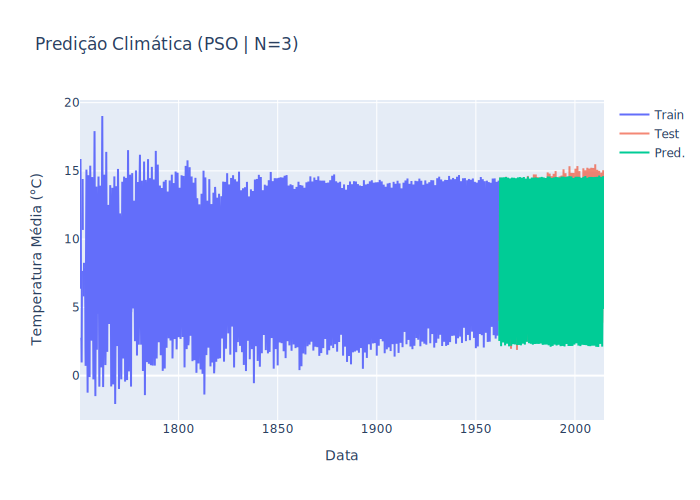

In [56]:
import plotly.graph_objects as go

X_plot_train = pd.DataFrame(X_train, columns=X.columns)
X_plot_train['dt'] = data_lagged[data_lagged.index < X_plot_train.shape[0]]['dt']
X_plot_train['LandAverageTemperature'] = y_train

X_plot_test = pd.DataFrame(X_test, columns=X.columns)
X_plot_test['dt'] = data_lagged[data_lagged.index >= X_plot_train.shape[0]]['dt'].reset_index(drop=True)
X_plot_test['LandAverageTemperature'] = y_test.reset_index(drop=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=X_plot_train['dt'], y=X_plot_train['LandAverageTemperature'], mode='lines', name='Train'))
# fig.add_trace(go.Scatter(x=X_plot_test['dt'], y=X_plot_test['LandAverageTemperature'], mode='lines', name='Test', opacity=0.7))
fig.add_trace(go.Scatter(x=X_plot_test['dt'], y=pd.Series(y_pred.flatten()), mode='lines', name='Pred.'))
fig.update_layout(title="Predição Climática (PSO | N=3)", yaxis_title="Temperatura Média (°C)", xaxis_title="Data")
fig.show("svg")

In [57]:
df_history = pd.DataFrame(pso.history, columns=['RMSE'])
df_history.to_csv("pso_results/PSO_N3_8.csv", index=False)

N=5
1 0.9100
2 1.2137
3 0.7949
4 0.9215
5 0.9202
6 0.9383

n=3
1 0.8696
2 0.7428
3 0.8028
4 0.8072
5 0.7604
6 0.7587
7 0.7130